# Телеком 📞

## Описание проекта

Компания предоставляет разные телефонные услуги. В нашем распоряжении данные телеком компании: personal.csv - о клиентах, contact.csv - о договорах с клиентами, internet.csv - об интернет услугах, phone.csv - об услугах телефонии. Необходимо построоить модель, которая будет предсказывать, уйдет ли клиент от компании или нет.

## План работы

#### Предобработка данных
Нужно объединить все таблицы вместе, избавиться от выбросов
#### Исследоваиельский анализ данных
Посмотреть на распредления признаков.
#### Построение модели
Посмотреть разные модеои с разными гиперпараметрами
#### Построить метрики
Посмотреть на метрики лучшей модели на тестовых данных, чтобы показать ее эффективность
#### Вывод
Написать краткий вывод, чтобы можно было понять, какие модели были использованы, и какая была использована на тестовых данных

## Предобработка данных

In [1]:
from tqdm import notebook
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from scipy.stats import boxcox

from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
contact_df = pd.read_csv('/datasets/final_provider/contract.csv')
internet_df = pd.read_csv('/datasets/final_provider/internet.csv')
personal_df = pd.read_csv('/datasets/final_provider/personal.csv')
phone_df = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
contact_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [4]:
internet_df

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [5]:
personal_df

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [6]:
phone_df

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [7]:
contact_df['customerID'].nunique(), internet_df['customerID'].nunique(), \
personal_df['customerID'].nunique(), phone_df['customerID'].nunique()

(7043, 5517, 7043, 6361)

In [8]:
contact_df['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

In [9]:
contact_df['churn'] = contact_df['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

In [10]:
df = contact_df.merge(personal_df, on='customerID', how='left')
df = df.merge(internet_df, on='customerID', how='left')
df = df.merge(phone_df, on='customerID', how='left')
df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,0,Male,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,0,Female,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,Female,...,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,1,Male,...,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [11]:
df.describe(include='all')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043.000000,7043,...,7043,7043,5517,5517,5517,5517,5517,5517,5517,6361
unique,7043,77,5,3,2,4,NaN,6531,NaN,2,...,2,2,2,2,2,2,2,2,2,2
top,7733-UDMTP,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,20.2,NaN,Male,...,No,No,Fiber optic,No,No,No,No,No,No,No
freq,1,366,5174,3875,4171,2365,NaN,11,NaN,3555,...,3641,4933,3096,3498,3088,3095,3473,2810,2785,3390
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,0.265370,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,0.441561,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.loc[df['EndDate'] == 'No', 'EndDate'] = '2020-02-01 00:00:00'

In [13]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['EndDate'] = pd.to_datetime(df['EndDate'])
life_time = df['EndDate'] - df['BeginDate']
life_time = life_time.apply(lambda y: int(str(y)[-15::-1][::-1]))
df['life_time'] = life_time

In [14]:
for col in notebook.tqdm(df.columns):
    if df[col].nunique() == 2 and col != 'churn':
        less_popular = df[col].value_counts().sort_values(ascending=False).index[1]
        df[col] = df[col].apply(lambda x: 1 if x == less_popular else 0) #заменяем NaN более популярными значениями

  0%|          | 0/22 [00:00<?, ?it/s]

In [15]:
df[df['TotalCharges'] == 0]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,gender,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,life_time


Просто так перевести TotalCharges в float не получается, поэтому заметим, что в данных нет нулевых значение из этого столбца. Напишем функцию для обработки данного столбца

In [16]:
def column_to_float(x):
    try:
        return float(x)
    except:
        return None

In [17]:
df['TotalCharges'] = df['TotalCharges'].apply(column_to_float)

In [18]:
df[df['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,gender,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,life_time
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,0,Bank transfer (automatic),52.55,NaN,0,1,...,1,1,1,0,1,1,1,0,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,1,Mailed check,20.25,NaN,0,0,...,1,0,0,0,0,0,0,0,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,1,Mailed check,80.85,NaN,0,1,...,1,1,1,1,1,0,1,1,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,1,Mailed check,25.75,NaN,0,0,...,1,0,0,0,0,0,0,0,1,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,1,Credit card (automatic),56.05,NaN,0,1,...,1,1,1,1,1,1,1,0,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,1,Mailed check,19.85,NaN,0,0,...,1,0,0,0,0,0,0,0,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,1,Mailed check,25.35,NaN,0,0,...,1,0,0,0,0,0,0,0,1,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,1,Mailed check,20.00,NaN,0,1,...,1,0,0,0,0,0,0,0,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,0,Mailed check,19.70,NaN,0,0,...,1,0,0,0,0,0,0,0,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,1,Mailed check,73.35,NaN,0,1,...,1,1,0,1,1,1,1,0,1,0


Заметим, что все пропуски только там, где клиент присоединился в 1 февраля 2020 года, то есть у него нет трат. Заполним их нулями 

In [19]:
df.loc[df['TotalCharges'].isna(), 'TotalCharges'] = 0

Перенесено ниже. Корреляция не проверялась, так как была убрана регрессионаая модель

In [20]:
df = df.drop(['EndDate', 'BeginDate'], axis=1)

In [21]:
df = df.drop('customerID', axis=1)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   int64  
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   churn             7043 non-null   int64  
 6   gender            7043 non-null   int64  
 7   SeniorCitizen     7043 non-null   int64  
 8   Partner           7043 non-null   int64  
 9   Dependents        7043 non-null   int64  
 10  InternetService   7043 non-null   int64  
 11  OnlineSecurity    7043 non-null   int64  
 12  OnlineBackup      7043 non-null   int64  
 13  DeviceProtection  7043 non-null   int64  
 14  TechSupport       7043 non-null   int64  
 15  StreamingTV       7043 non-null   int64  
 16  StreamingMovies   7043 non-null   int64  


## Исследовательский анализ данных

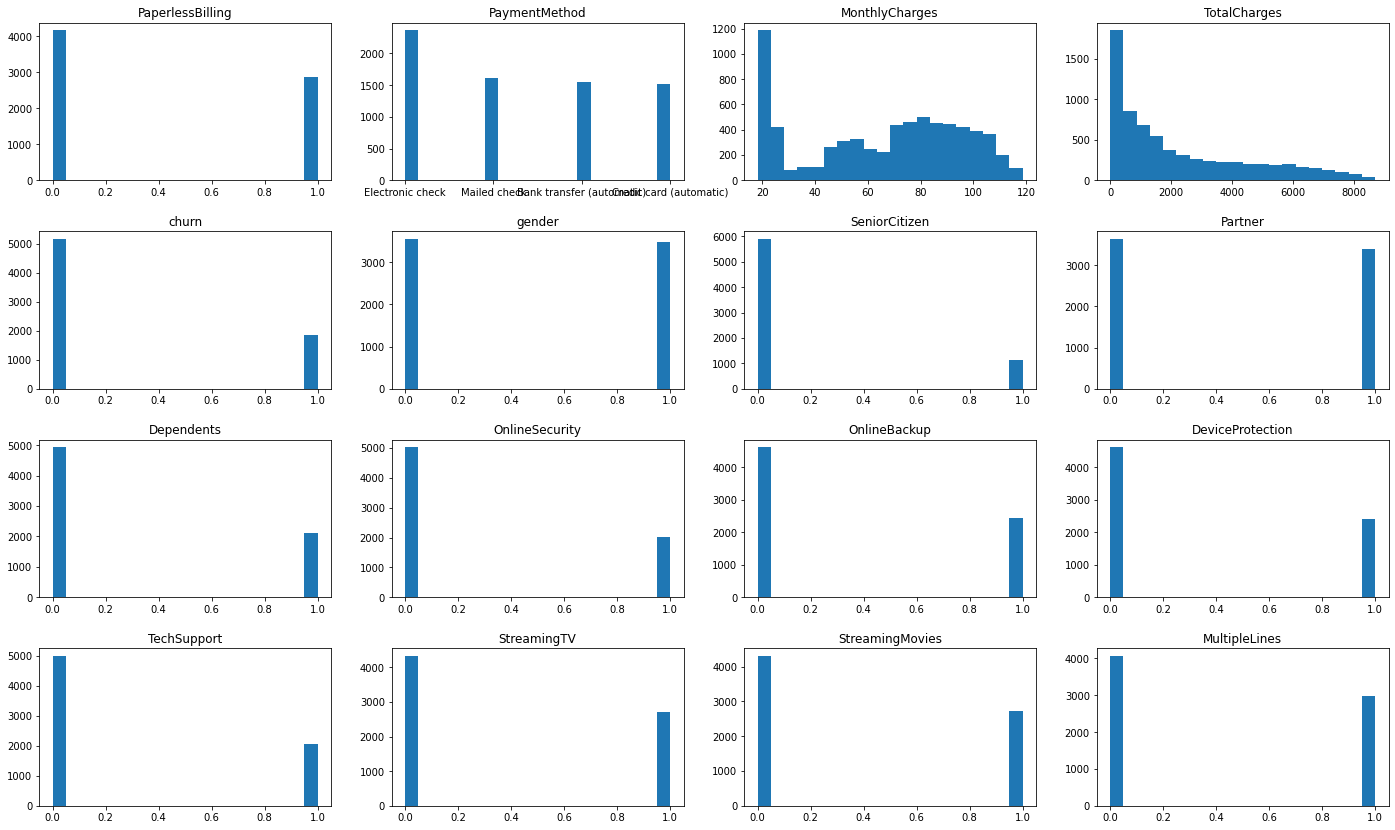

In [23]:
numeric_columns = ['PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', \
                   'churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', \
                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', \
                   'MultipleLines']
fig, ax = plt.subplots(4, 4, figsize=(20, 12))
fig.tight_layout(pad=3.0)
for row in range(4):
    for col in range(4):
        ax[row, col].hist(df[numeric_columns[row * 4 + col]], bins=20)
        ax[row, col].set_title(numeric_columns[row * 4 + col])

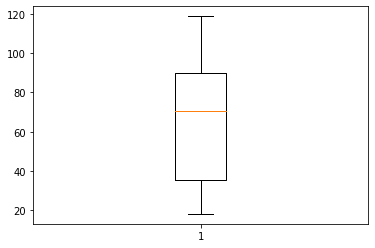

In [24]:
plt.boxplot(df['MonthlyCharges'])
plt.show()

In [25]:
transformed_data, best_lambda = boxcox(df['TotalCharges'] + 1)

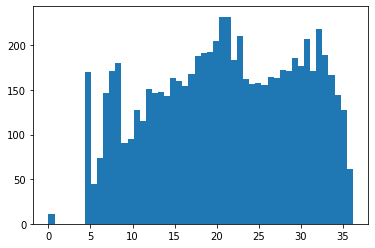

In [26]:
plt.hist(transformed_data, bins=50)
plt.show()

In [27]:
df['totalChargeLog'] = transformed_data

In [28]:
df['churn'].value_counts()

0    5174
1    1869
Name: churn, dtype: int64

Наблюдается явный дисбаланс, с которым придется бороться. Буду использовать сбалансированность классов

## Построение модели

In [29]:
df = pd.get_dummies(df, drop_first=True)
df

,PaperlessBilling,MonthlyCharges,TotalCharges,churn,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,MultipleLines,life_time,totalChargeLog,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,29.85,29.85,0,1,0,1,0,1,0,...,0,0,0,31,5.504499,0,0,0,1,0
1,1,56.95,1889.50,0,0,0,0,0,1,1,...,0,0,0,1036,23.184343,1,0,0,0,1
2,0,53.85,108.15,1,0,0,0,0,1,1,...,0,0,0,61,9.111801,0,0,0,0,1
3,1,42.30,1840.75,0,0,0,0,0,1,1,...,0,0,0,1371,23.003022,1,0,0,0,0
4,0,70.70,151.65,1,1,0,0,0,0,0,...,0,0,0,61,10.283225,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,84.80,1990.50,0,0,0,1,1,1,1,...,1,1,1,730,23.549223,1,0,0,0,1
7039,0,103.20,7362.90,0,1,0,1,1,0,0,...,1,1,1,2191,34.520564,1,0,1,0,0
7040,0,29.60,346.45,0,1,0,1,1,1,1,...,0,0,0,337,13.622046,0,0,0,1,0
7041,0,74.40,306.60,1,0,1,1,0,0,0,...,0,0,1,123,13.081868,0,0,0,0,1


Разделим данные в отношении 50:25:25

In [30]:
RANDOM_STATE=180123

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('churn', axis=1), \
                                                      df['churn'], test_size=0.25, random_state=RANDOM_STATE)

Пропущенных значений нет, все данные численные, поэтому они готовы к построению модели

In [32]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

### CatBoost 🐈😺

standart catboost

In [33]:
cat = CatBoostClassifier(verbose=False, random_state=RANDOM_STATE, class_weights=class_weights)

In [34]:
cat.fit(X_train, y_train)

In [35]:
cross_val_score(cat, X_train, y_train, scoring='roc_auc', cv=3).mean()

0.8818873911671554

catboost with grid search

In [36]:
cat = CatBoostClassifier(verbose=False, random_state=RANDOM_STATE, learning_rate=0.03, class_weights=class_weights)
params = {'iterations': [300, 1000], 'max_depth': [4, 6, 12]}
#grid_cat = GridSearchCV(cat, params, cv=5)

In [37]:
%%time
#grid_cat.fit(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


Поиск лучших гиперпараметров занял больше пяти минут, поэтому я закомментировал эту ячейку с кодом, но оставил найденные гиперпараметры в итоговой модели

In [38]:
#best_cat = grid_cat.best_estimator_
#cross_val_score(best_cat, X_train, y_train, scoring='roc_auc', cv=3).mean()

In [39]:
#grid_cat.best_params_

In [40]:
best_cat = CatBoostClassifier(verbose=False, random_state=RANDOM_STATE, learning_rate=0.03, max_depth=6, \
                              iterations=1000, class_weights=class_weights)
cross_val_score(best_cat, X_train, y_train, scoring='roc_auc', cv=3).mean()

0.8866142709900305

### Random Forest 🌳🌲

In [41]:
forest = RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE, class_weight='balanced')

In [42]:
forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=180123)

In [43]:
cross_val_score(forest, X_train, y_train, scoring='roc_auc', cv=3).mean()

0.8401276864544315

In [44]:
params_forest = {'max_depth': range(3, 25, 3), 'n_estimators': range(100, 600, 200)}
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=RANDOM_STATE)
grid_forest = GridSearchCV(forest, params_forest, cv=3)

In [45]:
%%time
grid_forest.fit(X_train, y_train)

CPU times: user 1min 38s, sys: 1.18 s, total: 1min 40s
Wall time: 2min 33s


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=180123),
             param_grid={'max_depth': range(3, 25, 3),
                         'n_estimators': range(100, 600, 200)})

In [46]:
best_forest = grid_forest.best_estimator_
cross_val_score(best_forest, X_train, y_train, scoring='roc_auc', cv=3).mean()

0.8445156955408084

In [47]:
grid_forest.best_params_

{'max_depth': 18, 'n_estimators': 500}

### XGBoost

In [48]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [49]:
xgb = XGBClassifier(random_state=RANDOM_STATE, verbosity=0, alpha=5, learning_rate=0.03)

In [50]:
xgb.fit(X_train, y_train, sample_weight=classes_weights)

XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=180123,
              reg_alpha=5, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [51]:
cross_val_score(xgb, X_train, y_train, scoring='roc_auc', cv=3).mean()

0.8602442139412475

In [52]:
params_xgb = {'max_depth': range(3, 25, 3), 'n_estimators': range(100, 600, 200)}
xgb = XGBClassifier(random_state=RANDOM_STATE, verbosity=0, alpha=5, learning_rate=0.05)
#grid_xgb = GridSearchCV(xgb, params_xgb, cv=3)

In [53]:
%%time
#grid_xgb.fit(X_train, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


In [54]:
#best_xgb = grid_xgb.best_estimator_
#cross_val_score(best_xgb, X_train, y_train, scoring='roc_auc', cv=3).mean()

In [55]:
#grid_xgb.best_params_

In [56]:
best_xgb = XGBClassifier(random_state=RANDOM_STATE, n_estimators=500, max_depth=3, verbosity=0, alpha=5, learning_rate=0.05)
cross_val_score(best_xgb, X_train, y_train, scoring='roc_auc', cv=3).mean()

0.8735633658033936

##  Метрики

In [57]:
model = CatBoostClassifier(verbose=False, random_state=RANDOM_STATE, max_depth=6, iterations=1000, \
                           learning_rate=0.03, class_weights=class_weights)
model.fit(X_train, y_train)

In [58]:
predictions = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, predictions)

0.907771249302103

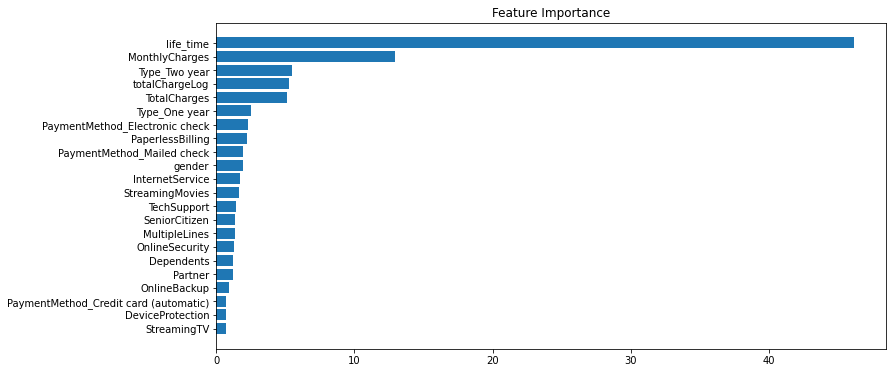

In [59]:
importance = model.feature_importances_
sorted_idx = np.argsort(importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

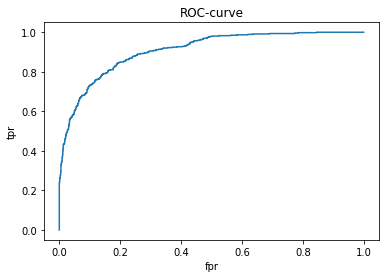

In [60]:
fpr, tpr, _ = roc_curve(y_test,  predictions)
plt.title('ROC-curve')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot(fpr,tpr)
plt.show()

## Вывод

Все пункты плана были выполнены.
Трудностей почти не было, если и были, то были только в том, что невнимательно прочитал памятку по проекту.
Ключевым шагом было создание фичи life_time, после которой очень возросло качество предсказаний.
В данной работе были предобработаны данные, удалены пропуски, все признаки переведены в int или float. Проблема дисбаланса классов решена с помощью весов классов. Были построены catboost, xgboost и случайный лес. В моделях исполоьзовались следующие признаки: 

['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'life_time',
       'totalChargeLog', 'Type_One year', 'Type_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
       
где lifetime - время жизни клиента до настоящего момента, totalChargeLog - преобразованный методом Бокса-Кокса признак TotalCharges, а остальные признаки - признаки с исходных таблиц, некоторые из них были преобразованы с помощью one hot encoding. Так же для этих признаков были посчитаны feature importances.

Лучшей моделью оказался catboost с 1000 интерациями и максимальной глубиной 6. Данная модель показала <b>roc_auc_score = 0.90</b>.